# packages

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
import time
from scipy.signal import correlate2d as Conv2D
import ffmpeg 
from skimage.segmentation import felzenszwalb
from skimage.segmentation import active_contour
from scipy.spatial import Delaunay as get_triangles
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr

<div dir='rtl'>

تابعی که عکس را خوانده و به فضای رنگ RGB می برد.

</div>

In [6]:
def read_image(name):
    return cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)

<div dir = 'rtl'>

# سوال اول
</div>

<div dir='rtl'>

## خواندن تصاویر 

عکس های مبدا و مقصد از قبل هم جهت(از نظر تمایل سر به راست یا چپ) و هم اندازه شده اند.

</div>

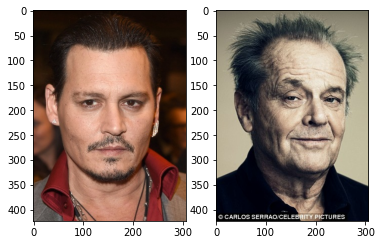

In [203]:
morphing_source_image = read_image('source.jpg')
morphing_destination_image = read_image('destination.jpg')
f, a = plt.subplots(1, 2)
a[0].imshow(morphing_source_image)
a[1].imshow(morphing_destination_image)


<div dir='rtl'>

## مختصات نقاط کلیدی روی صورت ها
به کمک `matplot.pyplot` این نقاط از قبل انتخاب شده و خروجی آنها در متن کد قرار داده شده است، به دلیل اینکه `matplot` مختصات طول و عرض را جابه جا تحویل می دهد آنهارا با `np.flip` اصلاح می کنیم.


</div>

In [204]:
source_points = np.array([
 [0, 0],
 [158.26818182,  11.03636364],
 [ 98.38896104,  69.81688312],
#  [147.28116883,  84.1       ],
 [218.1474026 ,  74.21168831],
#  [120.36298701, 115.41298701],
#  [193.42662338, 116.51168831],
 [252.75649351,  65.97142857],
 [159.36688312, 134.64025974 - 10],
 [ 39.05909091,  77.50779221],
 [101.13571429, 165.95324675],
 [140.68896104, 168.7       ],
 [187.93311688, 174.19350649],
 [226.38766234, 169.24935065],
 [ 27.52272727, 179.68701299],
 [ 85.7538961 , 189.57532468],
 [114.86948052, 189.02597403],
 [163.76168831, 185.18051948],
 [198.37077922, 187.92727273],
 [232.97987013, 188.47662338],
 [257.1512987 , 194.51948052],
 [ 97.83961039, 234.07272727],
 [170.90324675, 236.81948052],
 [220.34480519, 236.81948052],
 [ 69.82272727, 289.00779221],
 [117.06688312, 280.76753247],
 [199.46948052, 284.06363636],
 [130.2512987 , 334.6038961 ],
 [185.18636364, 336.25194805],
 [227.48636364, 289.55714286],
 [159.36688312, 403.27272727],
 [0, 423],
 [306, 0],
 [306, 423],
 [40, 225]])

destination_points = np.array([
[0, 0],
 [176.74373117,  14.82516873],
 [115.24925549,  52.83993551],
#  [199.47805248,  70.72923752],
 [225.19392412,  59.54842376 + 15],
#  [167.42638637,  96.07241537],
#  [227.80278067,  97.19049675],
 [280.72529912 - 20,  82.28274507 - 20],
 [200.59613385, 120.29751185 - 15],
 [ 31.02045851,  93.09086504],
 [126.05737546, 147.13146487],
 [174.88026221, 148.99493383],
 [218.48543587, 158.31227863],
 [250.16440818, 162.41191034],
 [ 41.08319089, 197.81782058],
 [122.70313133, 179.55582477],
 [150.28247194, 178.81043719],
 [200.59613385, 173.96541789],
 [231.52971859, 179.92851856],
 [249.4190206 , 182.9100689 ],
 [271.78064812, 190.36394474],
 [129.78431338, 227.63332394],
 [210.28617244, 220.1794481 ],
 [250.53710198, 223.90638602],
 [ 87.2972211 , 264.53000934],
 [154.75479744, 257.0761335 ],
 [231.15702479, 260.80307142],
 [165.19022362, 318.19791538],
 [219.60351724, 317.82522159],
 [247.18285785, 287.26433065],
 [177.48911875, 400.56324341],
 [0, 423],
 [306, 0],
 [306, 423],
 [60, 240]])

source_points = np.flip(source_points, axis = 1)
destination_points = np.flip(destination_points, axis = 1)

<div dir='rtl'>

## مثلث بندی
به کمک `scipy.spatial.Delaunay` که تحت عنوان `get_triangles` ایمپورت شده مثلث بندی حاصل از نقاط کلیدی مبدا و مقصد را محاسبه می کنیم.


</div>

In [205]:
source_tri = get_triangles(source_points)
destination_tri = get_triangles(destination_points)


<div dir='rtl'>

## محاسبه رنگ پیکسل های فریم های میانی

* برای پیدا کردن مختصات نقاط کلیدی در عکس های میانی، ابتدا آرایه ای می سازیم  

<div dir='ltr'>

$FRAME\_NUMBER \times n \times 2$
</div>


که مختصات نقطه کلیدی  `i` ام در فریم میانی `j` ام در درایه های `dots[i, j, 0:2]` قرار دارند، در این آرایه به کمک vectorization، ضرایب میانگین گیری وزن دار به ازا هر فریم میانی را در مختصات نقاط مبدا و مقصد ضرب کرده و میانگین را در درایه های مورد نظر قرار می دهیم.

* آرایه ی دیگری تولید می کنیم که مختصات تمام پیکسل های یک فریم را در یک آرایه $(h \times w) \times 2$ نگهداری کرده، از این ارایه برای بدست آوردن اندیس مثلثی که یک پیکسل در یک فریم میانی را در بر گرفته استفاده می کنیم

* به ازا هر فریم میانی:
    * شی متناظر مثلث بندی برای نقاط کلیدی این فریم را بدست می آوریم و با استفاده از آن اندیس مثلث در برگیرنده هر پیکسل را بدست می آوریم
    * به ازا هر پیکسل:
        *  اندیس نقاط کلیدی در لیست این نقطه ها،که روی راس های مثلث در برگیرنده قرار دارند پیدا می کنیم
        * مختصات این پیکسل بر پایه بردار های متناظر دو ضلع مثلث در برگیرنده را پیدا می کنیم
        * به کمک این مختصات جدید پیکسل های متناظر در عکس مبدا و مقصد را پیدا کرده، میانگین وزن دارن رنگ های آنهارا حساب می کنیم
</div>

In [207]:

FRAME_NUMBER = 45

frame_points = (destination_points - source_points) * np.arange(FRAME_NUMBER).reshape((-1, 1, 1)) / FRAME_NUMBER + source_points.reshape((1, -1, 2))
x = np.arange(morphing_destination_image.shape[0]).reshape((-1, 1)) * np.ones(morphing_destination_image.shape[1]).reshape((1, -1))
y = np.arange(morphing_destination_image.shape[1]).reshape((1, -1)) * np.ones(morphing_destination_image.shape[0]).reshape((-1, 1))
dots = np.stack([x, y], axis = 2)
flatten_dots = dots.reshape((-1, 2))
for i in range(1, FRAME_NUMBER):
    print(i)
    current_tri = get_triangles(frame_points[i,:])
    labels = current_tri.find_simplex(flatten_dots).reshape(morphing_destination_image.shape[:2])
    image = np.zeros(morphing_destination_image.shape)
    for x in range(morphing_destination_image.shape[0]):
        for y in range(morphing_destination_image.shape[1]):
            if labels[x, y] == -1:
                continue
            indices = current_tri.simplices[labels[x,y],:]
            relative_point = np.array([x, y]) - frame_points[i, indices[0], :]
            relative_A = frame_points[i, indices[1],:] - frame_points[i, indices[0], :]
            relative_B = frame_points[i, indices[2], :] - frame_points[i, indices[0], :]
            combination = np.matmul(np.linalg.pinv(np.hstack([relative_A.reshape((-1,1)), relative_B.reshape((-1,1))])),
                                     relative_point.reshape((-1, 1)))
            relative_A = source_points[indices[1], :] - source_points[indices[0], :]
            relative_B = source_points[indices[2], :] - source_points[indices[0], :]
            coordinants = relative_A * combination[0] + relative_B * combination[1] + source_points[indices[0], :]
            coordinants = coordinants.astype(int)
            image[x, y, :] = (FRAME_NUMBER - i) / FRAME_NUMBER * morphing_source_image[coordinants[0], coordinants[1], :]
            
            relative_A = destination_points[indices[1], :] - destination_points[indices[0], :]
            relative_B = destination_points[indices[2], :] - destination_points[indices[0], :]
            coordinants = relative_A * combination[0] + relative_B * combination[1] + destination_points[indices[0], :]
            coordinants = coordinants.astype(int)
            image[x, y, :] += i / FRAME_NUMBER * morphing_destination_image[coordinants[0], coordinants[1], :]
    cv2.imwrite("output/image_" + str(100+i) + ".jpg", np.flip(image[:-1,:,:], axis = 2))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


<div dir='rtl'>

## ذخیره نتیجه
عکس های ابتدا و انتهایی را به پوشه عکس ها اضافه می کنیم؛
آدرس فریم های داخل پوشه خروجی را به `ffmpeg` داده و یک فیلم کوتاه از آنها تهیه می کنیم.
از آنجایی که `ffmpeg` در صورت وجود فایل با اسم مشابه برای بازنویسی فایل اجازه می خواد در نوت بوک این قسمت اگر قبلا خروجی در پوشه فعلی موجود باشد قابل اجرا نیست.
</div>

In [208]:
cv2.imwrite('output/image_100.jpg', np.flip(morphing_source_image[:-1,:,:], axis = 2))
cv2.imwrite('output/image_145.jpg', np.flip(morphing_destination_image[:-1,:,:], axis = 2))
ffmpeg.input('output/image_*.jpg', pattern_type='glob', framerate=10, ).output('morph.mp4').run()

ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/4.4.1_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample

(None, None)

<div dir='rtl'>

# سوال دوم
</div>

<div dir='rtl'>

## خواندن تصاویر مرجع و هدف
عکس های مورد نظر را خوانده ، به فضای رنگ RGB برده، و عکس مرجع را قرینه می کنیم تا در محل مورد نظر ما در عکس طبیعی بنظر بیاید، همچنین سفیدی اضافی اطراف عکس را پاک می کنیم

</div>

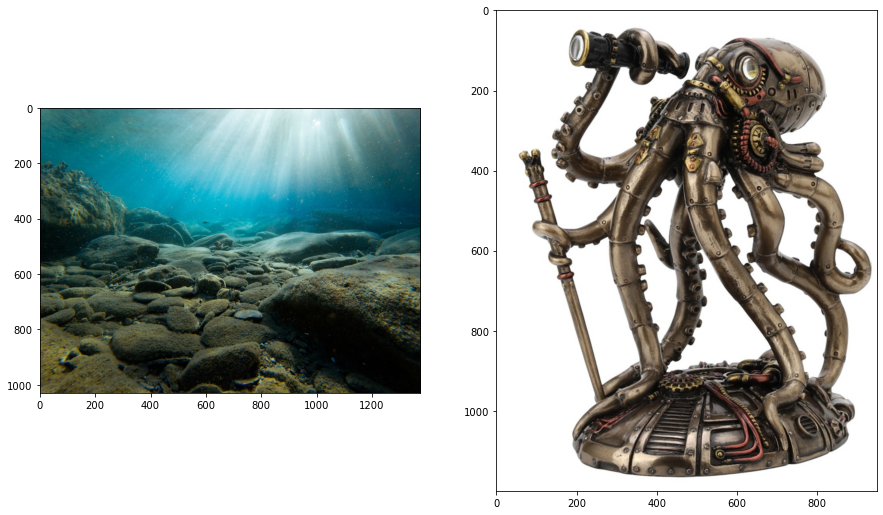

In [3]:
sea_bed_image = read_image('seabed.jpg')
octopus_image = read_image('octopus_2.jpg')[200:1400,350:1300,:]
octopus_image = np.flip(octopus_image, axis = 1)
octopus_image = np.where(octopus_image.mean(axis = 2, keepdims=True) == 0, 255, octopus_image)
f, a = plt.subplots(1, 2)
f.set_figwidth(15)
f.set_figheight(15)
a[0].imshow(sea_bed_image)
a[1].imshow(octopus_image)

<div dir='rtl'>

##  قرار دادن عکس منبع در هدف در عکس تک کاناله

* برای ادغام کردن ، به عنوان ورودی عکس ها و پیکسل هایی که مایل هستیم از منبع به مقصد بروند در آرایه `mask` دریافت می کنیم
* لبه بین پیکسل های منبع و اطراف آنرا به کمک $ mask - (B \oplus mask) $  که B همان فیلتر سه در سه است پیدا می کنیم
* در دستگاه معادلات پوآسون شرط لبه هارا اضافه می کنیم
* سپس در همین دستگاه شرط $ g \nabla = f ^2\nabla$ را به ازا پیکسل های داخل عکس منبع اضافه می کنیم.
* از آنجایی که ماتریس ضرایب دستگاه مقدار های ناصفر بسیار کمی دارد از `scipy.sparse` استفاده می کنیم تا دستگاه به صورت بهینه حل شود.
* بردار بدست آمده از حل دستگاه را به شکل آرایه دو بعدی تصویر برمی گردانیم
</div>

In [7]:
def blend_gray_scale(source, destination, laplacian, mask):
    h, w = source.shape
    index = np.arange(source.size).reshape(source.shape)
    sparse_row = []
    sparse_col = []
    sparse_data = []
    b = []
    edge = np.logical_and((Conv2D(mask, np.ones((3, 3)), mode='same') > 0) ,np.logical_not(mask))

    x, y = np.where(edge)
    for i in range(x.size):
            sparse_row.append(len(b))
            sparse_col.append(index[x[i], y[i]])
            sparse_data.append(1)
            b.append(destination[x[i], y[i]])

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if mask[i, j] : 
                sparse_row.append(len(b))
                sparse_col.append(index[i , j])
                sparse_data.append(-4)

                sparse_row.append(len(b))
                sparse_col.append(index[i - 1, j])
                sparse_data.append(1)

                sparse_row.append(len(b))
                sparse_col.append(index[i + 1, j])
                sparse_data.append(1)

                sparse_row.append(len(b))
                sparse_col.append(index[i, j - 1])
                sparse_data.append(1)

                sparse_row.append(len(b))
                sparse_col.append(index[i, j + 1])
                sparse_data.append(1)

                b.append(laplacian[i, j])
            

    b = np.array(b)
    M = coo_matrix((sparse_data, (sparse_row, sparse_col)), shape = (b.shape[0], index.size))
    print('<', end = '')
    res = lsqr(M, b)[0]
    print('>')
    res = res.reshape(source.shape)
    res = np.where(mask, res, destination)
    return res

 <div dir='rtl'>

## ادغام عکس های رنگی

کانال های عکس هارا جدا کرده، کانال های متناظر را به `blend_gray_scale` می دهیم و نتایج را مجددا در یک عکس RGB ادغام می کنیم.
 </div>

In [8]:
def blend(source, destination, background_color = 128):
    laplacian = cv2.Laplacian(source, ddepth=3)
    mask = source.mean(axis =2) != background_color
    res = np.stack([blend_gray_scale(source[:,:,0], destination[:,:,0], laplacian[:,:,0], mask),
                    blend_gray_scale(source[:,:,1], destination[:,:,1], laplacian[:,:,1], mask),
                    blend_gray_scale(source[:,:,2], destination[:,:,2], laplacian[:,:,2], mask)], axis = 2)
    return res, laplacian

 <div dir='rtl'>

## بدست آوردن نتیجه

* پیکسل های اطراف پیکسل های اصلی عکس منبع را خاکستری می کنیم تا لاپلاسین پیکسل های روی لبه مقدار های بسیار بزرگ به خود نگیرند
* عکس منبع را به اندازه کافی کوچک می کنیم تا در عکس هدف اندازه طبیعی داشته باشد
* قسمتی از عکس هدف که منبع در آن جای می گیرد را انتخاب کرده و آنرا در کنار عکس منبع به `blend` می دهیم.
 </div>

<>
<>
<

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>


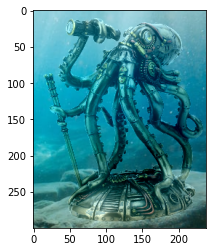

In [9]:
tmp_image = octopus_image
tmp_image = np.where(octopus_image.mean(axis = 2, keepdims=True) > 200, np.ones(3, dtype='uint8') * 128, octopus_image)
tmp_image = cv2.resize(tmp_image,dsize=(0, 0), fx = 1/4, fy  =1/4)
tmp_image_2 = sea_bed_image.copy()
tmp_image_2 = tmp_image_2[230:230+tmp_image.shape[0], 740:740+tmp_image.shape[1],:]
tmp, laplac = blend(tmp_image, tmp_image_2, background_color=128)
plt.imshow(tmp.astype(int))

<div dir='rtl'>

## قرار دادن عکس ادغام شده در عکس هدف اصلی
تصاویر ادغام شده را در عکس هدف اصلی جایگذاری می کنیم.
</div>

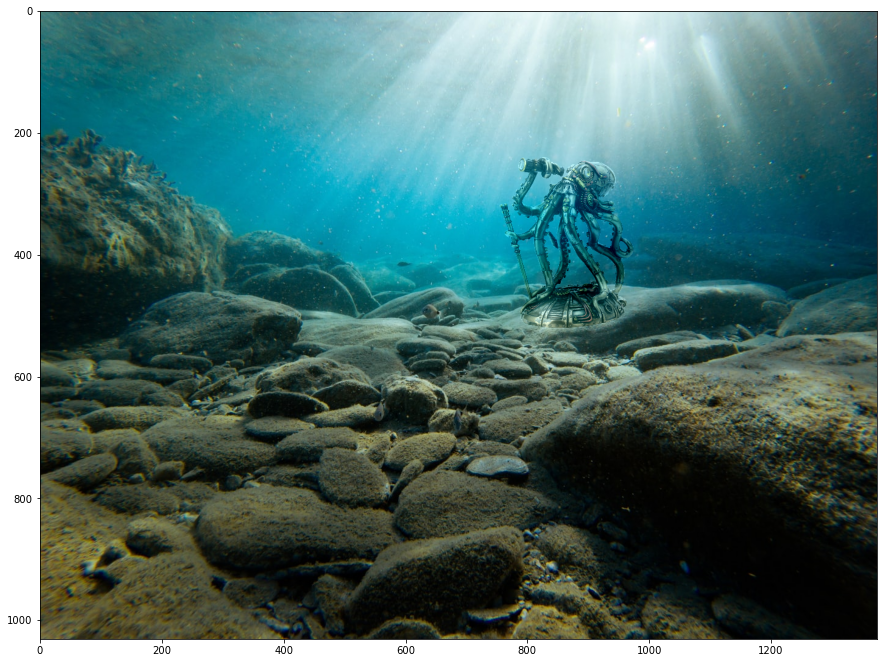

In [7]:
plt.figure(figsize=(15, 15))
bkgrd = cv2.resize(sea_bed_image, dsize=(0, 0), fx = 1, fy= 1)
bkgrd[230:230+tmp_image.shape[0], 740:740+tmp_image.shape[1],:] = np.maximum(np.minimum(tmp, 255), 0).astype('uint8')
plt.imshow(bkgrd)

In [12]:
cv2.imwrite('output.jpg', np.flip(bkgrd, axis =2))

True

<div dir='rtl'>

# سوال سوم    
</div>

<div dir='rtl'>

## خواندن عکس ها
عکس هایی که از قبل هم اندازه و محل طلاقی شان روی هم قرار داده شده را از فایل ها می خوانیم
</div>

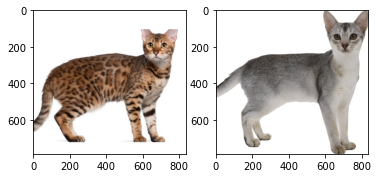

In [12]:
cat_1_image = read_image("res08.jpg")
cat_2_image = read_image("res09.jpg")

f, a = plt.subplots(1, 2)
a[0].imshow(cat_1_image)
a[1].imshow(cat_2_image)

<div dir='rtl'>

## ادغام دو عکس
* عکس ها، تعداد لایه های پشته لاپلاسین ، لیست شعاع ادغام در هر لایه و در نهایت لبه ادغام دو عکس(در راستای عمودی) را به عنوان ورودی دریافت می کنیم.
* در هر لایه عکس های لایه فعلی را در نظر می گیریم، ایندو را بلر می کنیم و اختلاف هر عکس با بلر شده آنرا حساب می کنیم تا mask unsharp بدست بیاید، روی لبه ورودی گرفته شده، و به شعاع داده شده، عکس هارا ادغام می کنیم و روی این ناحیه میانگین وزن دار از دو عکس را حساب می کنیم. این نتیجه را به مقدار های عکس نتیجه اضافه می کنیم،

* در مرحله آخر عکس های لایه آخر که بلر شده لایه های قبلی هستند را در ناحیه خواسته شده ادغام کرده به نتیجه اضافه می کنیم
* در نتیجه این جمع زدن ها مجموع همه لایه های پشته لاپلاسین به عکس نتیجه اضافه شده است

</div>

In [13]:
def blend_with_feathering(image1, image2, levels, feathering_extend, edge):
    res = np.zeros(image1.shape)
    tmp1 = image1.copy().astype(float)
    tmp2 = image2.copy().astype(float)
    for i in range(levels):
        mask = np.zeros((image1.shape[1]))
        mask[edge - feathering_extend[i]:edge + feathering_extend[i]] = 1 - np.arange(2 * feathering_extend[i]) / 2 / feathering_extend[i]
        mask[:edge - feathering_extend[i]] = 1
        mask[edge + feathering_extend[i]:] = 0
        mask = mask.reshape((1, -1, 1))
        blur_1 = cv2.GaussianBlur(tmp1, (3,3), 1)
        blur_2 = cv2.GaussianBlur(tmp2, (3,3), 1)
        res += mask * (tmp1 - blur_1) + (1 - mask) * (tmp2 - blur_2)
        tmp1 = blur_1
        tmp2 = blur_2
    
    mask = np.zeros((image1.shape[1]))
    mask[edge - feathering_extend[levels]:edge + feathering_extend[levels]] = 1 - np.arange(2 * feathering_extend[levels]) / 2 / feathering_extend[levels]
    mask[:edge - feathering_extend[levels]] = 1
    mask[edge + feathering_extend[levels]:] = 0
    mask = mask.reshape((1, -1 ,1))
    res += mask * tmp1 + (1 - mask) * tmp2

    return res

<div dir='rtl'>

## بدست‌آوردن نتیجه
عکس های از پیش آماده شده را به `blend_with_feathering` به همراه تعداد لایه های پشته ، شعاع ادغام کردن ها و لبه محل ادغام ورودی می دهیم و نتیجه را ذخیره می کنیم
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

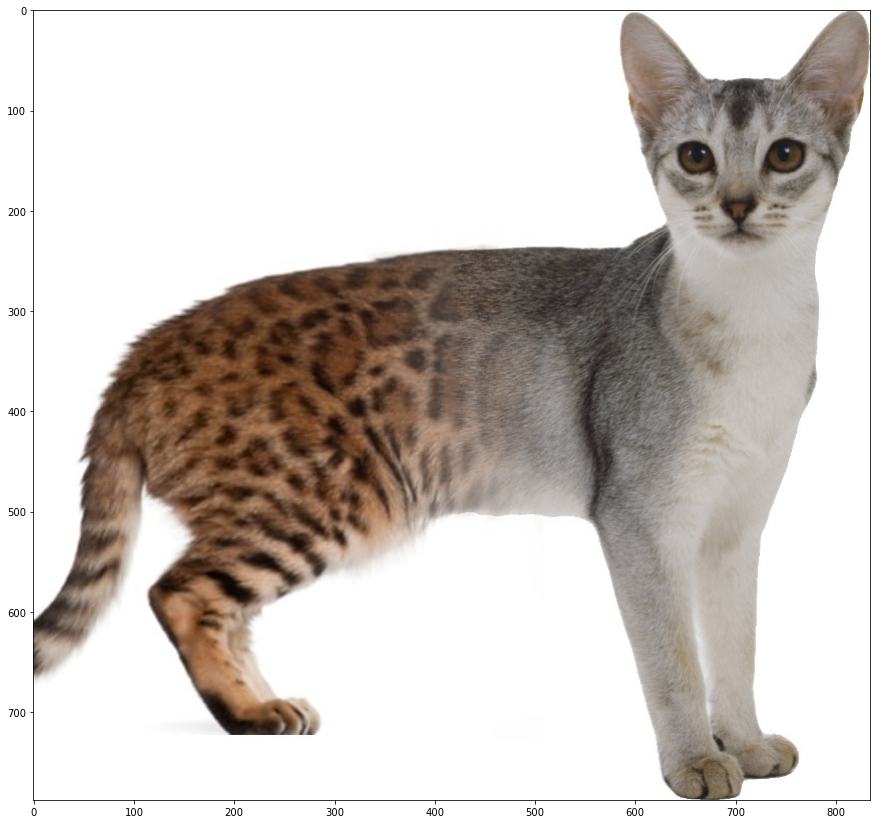

In [16]:
plt.figure(figsize=(15, 15))
res = blend_with_feathering(cat_1_image, cat_2_image, levels = 5, feathering_extend=[2,5, 11, 22, 45, 90],edge= 420)
plt.imshow(res.astype(int))
cv2.imwrite('res10.jpg', np.flip(res, axis=2))